# Ratledge analysis

Compare the predictions for models trained with different $\lambda_b$ values

In [1]:
import json
import os
import torch
import pandas as pd
import numpy as np
import configparser
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde

sns.set(style="whitegrid")

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

# Set seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, 

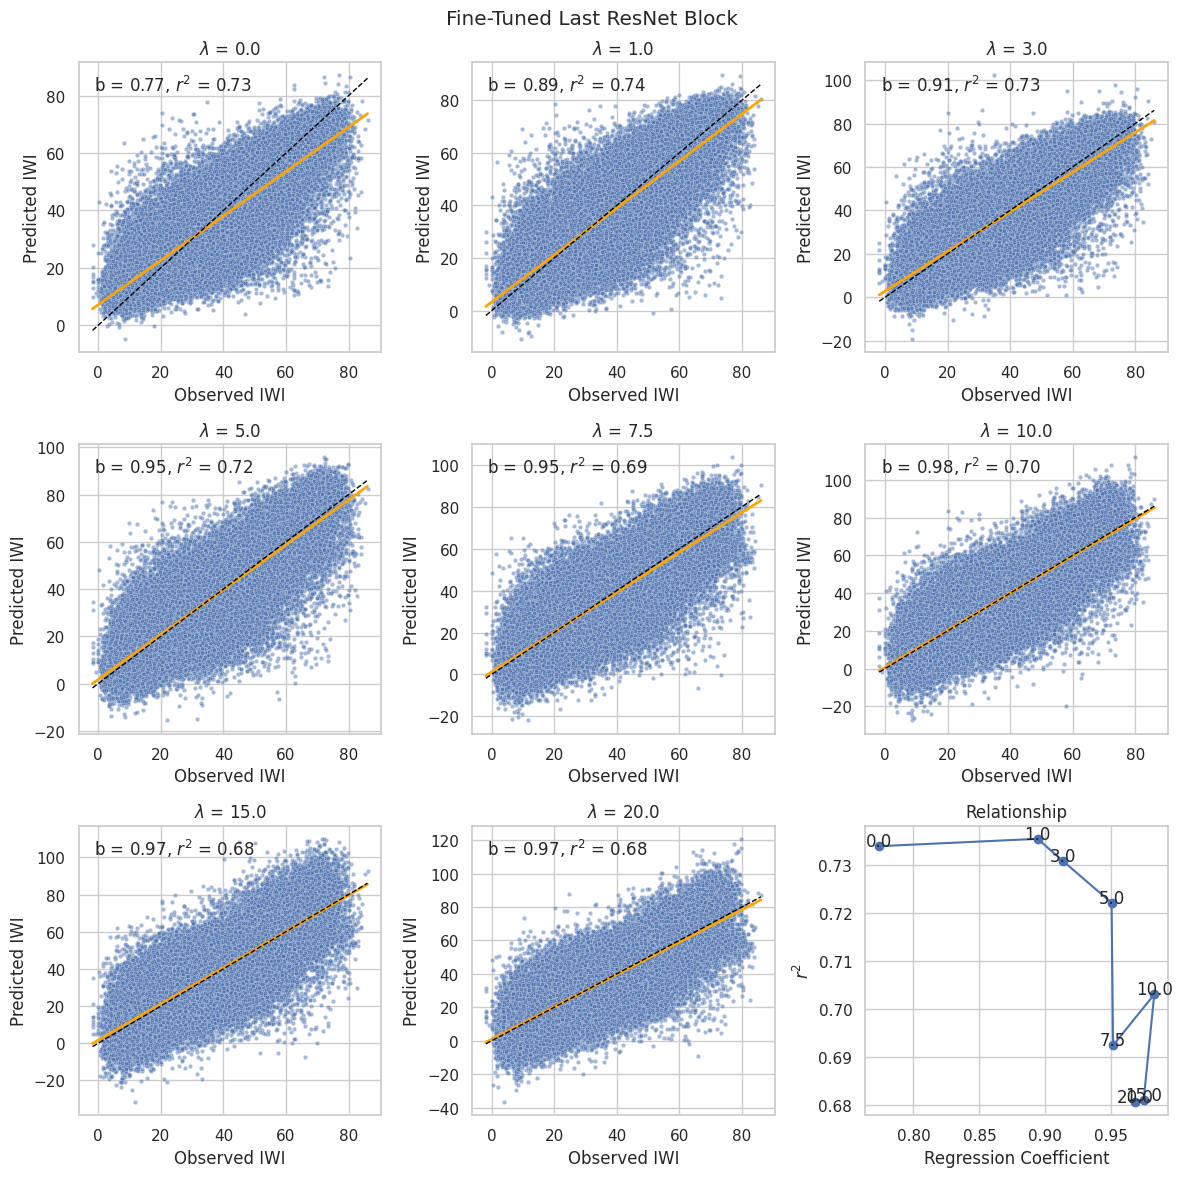

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, 

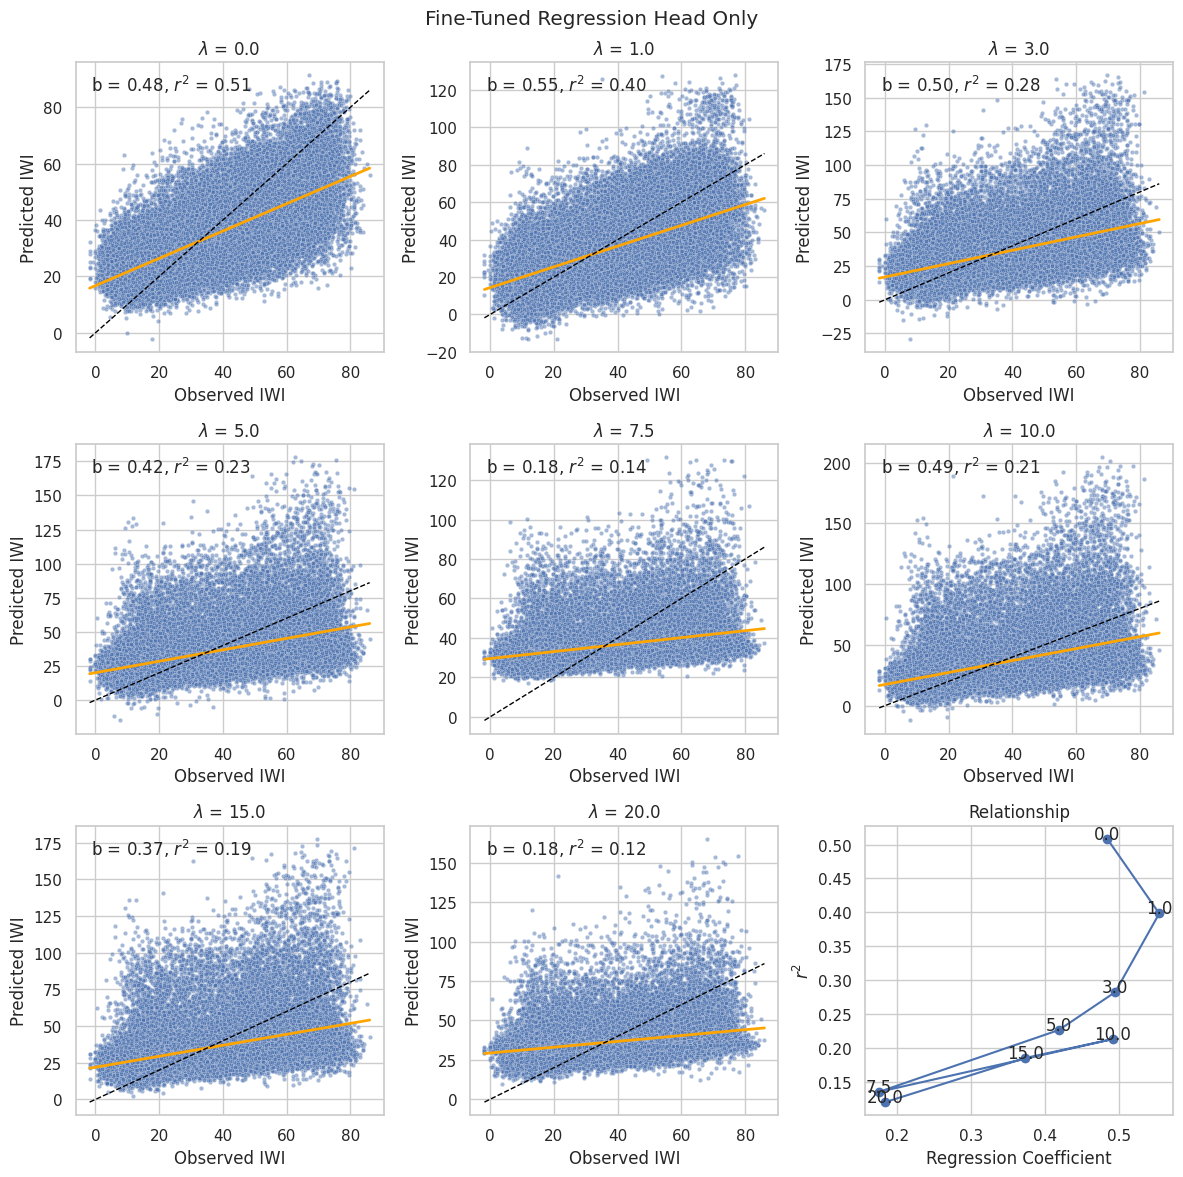

/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, 

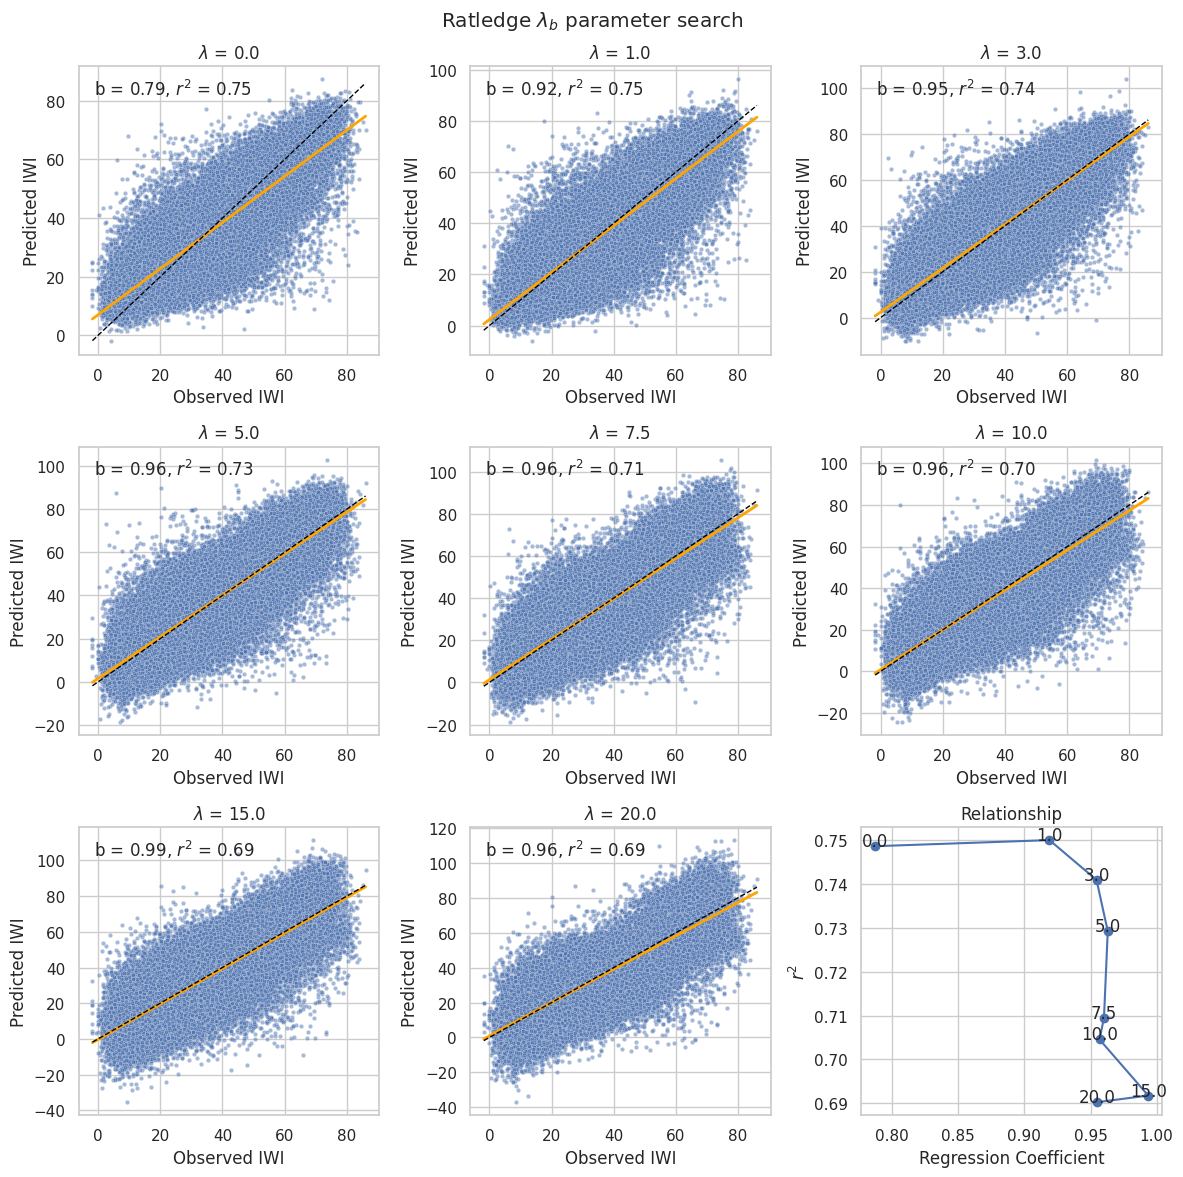

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def make_ratledge_plot(title, args_string='', country='Uganda'):

    slopes_ssa = []
    r2s_ssa = []
    slopes_uganda = []
    r2s_uganda = []

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()

    keys = ['0.0', '1.0', '3.0', '5.0', '7.5', '10.0', '15.0', '20.0']

    # Scatter plots
    for i, lam in enumerate(keys):
        #for i, (lam, df) in enumerate(dfs.items()):

        df_path = os.path.join(DATA_DIR, 'models', f'ratledge_lambda_b={lam}{args_string}', 'dhs_with_imgs_predictions.csv')

        # Check if the file exists
        if lam == '0.0':
            df_path = os.path.join(DATA_DIR, 'models', f'mse{args_string}', 'dhs_with_imgs_predictions.csv')
            df = pd.read_csv(df_path)
            is_default = False
        elif lam == '5.0':
            df_path = os.path.join(DATA_DIR, 'models', f'ratledge{args_string}', 'dhs_with_imgs_predictions.csv')
            df = pd.read_csv(df_path)
            is_default = False
        elif os.path.exists(df_path):
            df = pd.read_csv(df_path)
            is_default = False
        else:
            print(f"File not found for lambda_b={lam}. Using default predictions.")
            df = pd.read_csv(os.path.join(MODELS_DIR, 'dhs_with_imgs_predictions.csv'))
            is_default = True

        ax = axes[i]
        sns.scatterplot(data=df, x='iwi', y='iwi_hat', ax=ax, s=10, alpha=0.5)

        # Fit regression
        X = df[['iwi']]
        y = df['iwi_hat']
        model = LinearRegression().fit(X, y)
        y_pred = model.predict(X)
        b = model.coef_[0]
        r2 = r2_score(y, y_pred)

        # Plot regression line
        x_vals = np.linspace(df['iwi'].min(), df['iwi'].max(), 100).reshape(-1, 1)
        y_vals = model.predict(x_vals)
        ax.plot(x_vals, y_vals, color='orange', linewidth=2)

        # Plot y = x line for reference
        ax.plot(x_vals, x_vals, color='black', linestyle='--', linewidth=1)

        # Labels
        ax.set_title(f'$\lambda$ = {lam}' + (' (Placeholder)' if is_default else ''))
        ax.set_xlabel('Observed IWI')
        ax.set_ylabel('Predicted IWI')
        ax.text(0.05, 0.9, f'b = {b:.2f}, $r^2$ = {r2:.2f}', transform=ax.transAxes)

        # Store for summary
        slopes_ssa.append(b)
        r2s_ssa.append(r2)

        df_ug = df[df['country'] == country]
        X_ug = df_ug[['iwi']]
        y_ug = df_ug['iwi_hat']
        if len(df_ug) > 0:
            model_ug = LinearRegression().fit(X_ug, y_ug)
            y_ug_pred = model_ug.predict(X_ug)
            slopes_uganda.append(model_ug.coef_[0])
            r2s_uganda.append(r2_score(y_ug, y_ug_pred))
        else:
            slopes_uganda.append(np.nan)
            r2s_uganda.append(np.nan)

    # Summary plot
    ax = axes[-1]
    ax.plot(slopes_ssa, r2s_ssa, 'o-', label='Africa (All)')
    # ax.plot(slopes_uganda, r2s_uganda, 's--', label=country)

    for i, lam in enumerate(keys):
        ax.text(slopes_ssa[i], r2s_ssa[i], str(lam), ha='center', fontsize=12)

    ax.set_xlabel('Regression Coefficient')
    ax.set_ylabel('$r^2$')
    ax.set_title('Relationship')
    # ax.legend()

    plt.suptitle(title)
    plt.tight_layout()

make_ratledge_plot('Fine-Tuned Last ResNet Block')
plt.show()
make_ratledge_plot('Fine-Tuned Regression Head Only', args_string='_num_linear_epochs=30_num_top_epochs=0')
plt.show()
make_ratledge_plot('Ratledge $\lambda_b$ parameter search', args_string='_num_top_epochs=0_num_full_epochs=20')
plt.savefig('figures/ratledge_analysis.png', dpi=300)